In [1]:
! conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

/bin/bash: line 1: conda: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 856.7 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_7z3az63
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_7z3az63
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_c

In [2]:
import torch
import torchvision.models as models
from torchvision import transforms
import clip
import ast
from PIL import Image
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from torch.autograd.profiler import record_function
import logging
import socket
from datetime import datetime, timedelta

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)

print("CLIP Vision Encoder:")
print(model.encode_image)

100%|███████████████████████████████████████| 244M/244M [01:34<00:00, 2.71MiB/s]


CLIP Vision Encoder:
<bound method CLIP.encode_image of CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [4]:
def measure_time(model, image_path, half=False):
    image_tensor = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    if half:
        image_tensor.half()

    start_time = time.time()
    with torch.no_grad():
        model.encode_image(image_tensor)
    end_time = time.time()
    return end_time - start_time

In [5]:
model_half, preprocess_half = clip.load("RN50", device=device)
model_half.half()

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [6]:
time_diff = []
fp16_time = []
fp32_time = []

print(f'Clock time for fp32: {measure_time(model, "bird.jpeg")}s')
print(f'Clock time for fp16: {measure_time(model_half, "bird.jpeg", half=True)}s')

for i in range(100):
    time_diff.append(np.abs(measure_time(model, "bird.jpeg") - measure_time(model_half, "bird.jpeg", half=True)))
    fp16_time.append(measure_time(model_half, "bird.jpeg", half=True))
    fp32_time.append(measure_time(model, "bird.jpeg"))

print(f'Mean of time difference over 100 iterations: {np.mean(time_diff)}')
print(f'Standar Deviation of time difference over 100 iterations: {np.std(time_diff)}')
print(f'Mean of fp16 time over 100 iterations: {np.mean(fp16_time)}')
print(f'Standar Deviation of fp16 time over 100 iterations: {np.std(fp16_time)}')
print(f'Mean of fp32 time over 100 iterations: {np.mean(fp32_time)}')
print(f'Standar Deviation of fp32 time over 100 iterations: {np.std(fp32_time)}')

Clock time for fp32: 1.4769446849822998s
Clock time for fp16: 0.1122579574584961s
Mean of time difference over 100 iterations: 0.00670961856842041
Standar Deviation of time difference over 100 iterations: 0.00934979392963475
Mean of fp16 time over 100 iterations: 0.02014359474182129
Standar Deviation of fp16 time over 100 iterations: 0.017274161677150894
Mean of fp32 time over 100 iterations: 0.01961688995361328
Standar Deviation of fp32 time over 100 iterations: 0.018053371403492988


In [7]:
def classify(model1, image_path, half=False):
    with open("data.txt", "r") as file:
        labels = file.read()

    labels_dict = ast.literal_eval(labels)
    labels = list(labels_dict.values())
    text_label = [f"a photo of a {label}" for label in labels]
    text = clip.tokenize(text_label).to(device)

    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    if half:
      text.half()
      image.half()

    with torch.no_grad():
        image_features = model1.encode_image(image)
        text_features = model.encode_text(text)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    return similarity, text_label

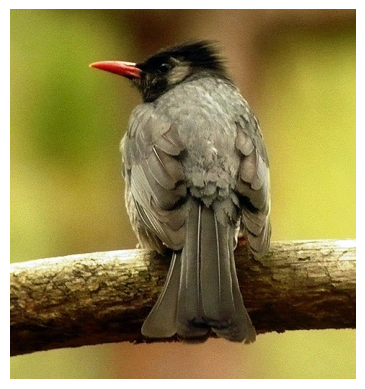


Top prediction:
a photo of a bulbul: 99.51%
a photo of a jacamar: 0.09%
a photo of a red-breasted merganser, Mergus serrator: 0.08%


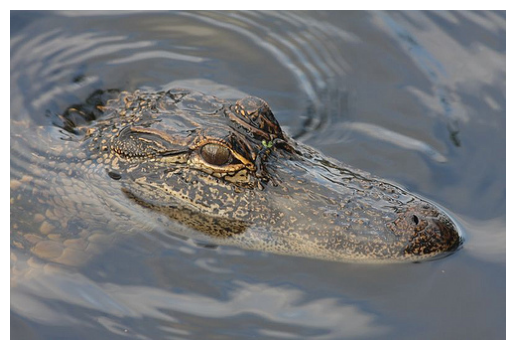


Top prediction:
a photo of a terrapin: 38.45%
a photo of a American alligator, Alligator mississipiensis: 23.68%
a photo of a mud turtle: 9.13%


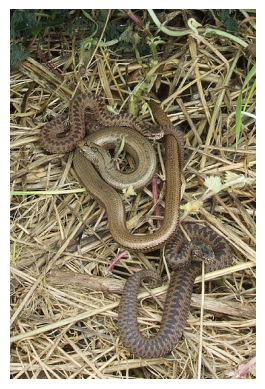


Top prediction:
a photo of a garter snake, grass snake: 56.88%
a photo of a thunder snake, worm snake, Carphophis amoenus: 19.06%
a photo of a night snake, Hypsiglena torquata: 3.93%


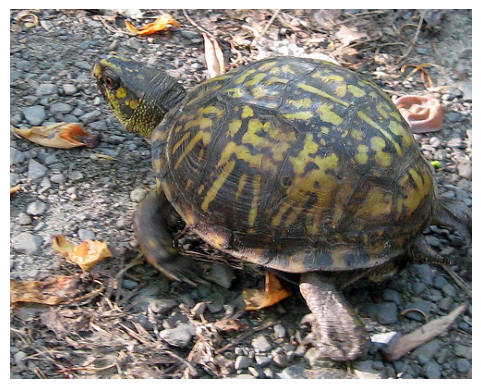


Top prediction:
a photo of a box turtle, box tortoise: 56.10%
a photo of a terrapin: 24.12%
a photo of a mud turtle: 17.10%


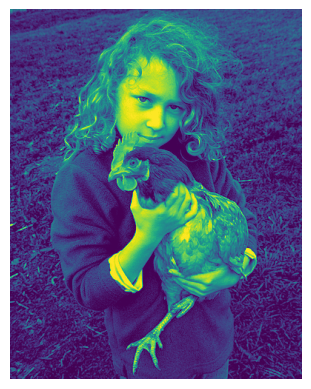


Top prediction:
a photo of a hen: 51.90%
a photo of a cock: 11.96%
a photo of a Brabancon griffon: 5.92%


In [8]:
images = ['bird.jpeg', 'crocodile.jpeg', 'snakes.jpeg', 'turtle.jpeg', 'hen.jpeg']


for image_path in images:
    similarity, labels = classify(model, image_path)
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.show()
    values, indices = similarity[0].topk(3)
    print("\nTop prediction:")
    for value, index in zip(values, indices):
        print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")

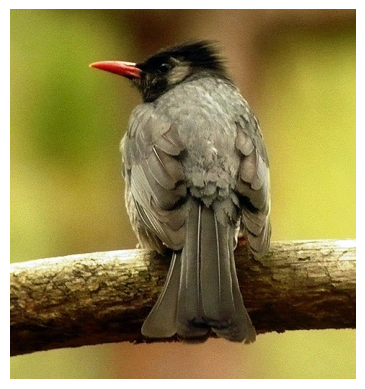


Top prediction:
a photo of a bulbul: 99.51%
a photo of a jacamar: 0.09%
a photo of a red-breasted merganser, Mergus serrator: 0.08%


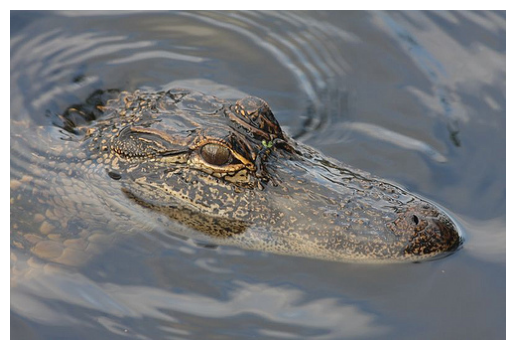


Top prediction:
a photo of a terrapin: 38.38%
a photo of a American alligator, Alligator mississipiensis: 23.65%
a photo of a mud turtle: 9.12%


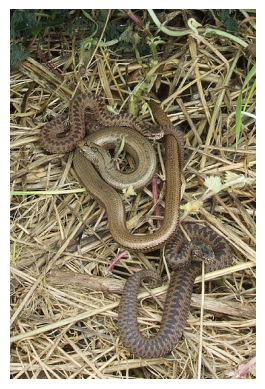


Top prediction:
a photo of a garter snake, grass snake: 57.18%
a photo of a thunder snake, worm snake, Carphophis amoenus: 18.85%
a photo of a hognose snake, puff adder, sand viper: 3.83%


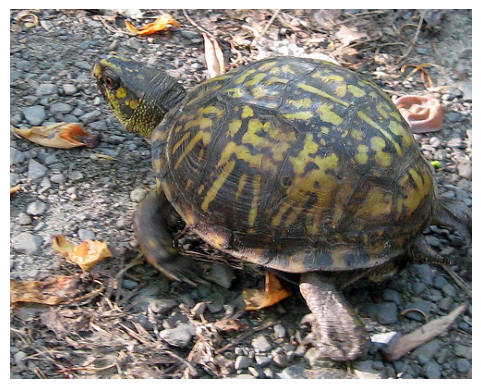


Top prediction:
a photo of a box turtle, box tortoise: 56.45%
a photo of a terrapin: 23.91%
a photo of a mud turtle: 16.96%


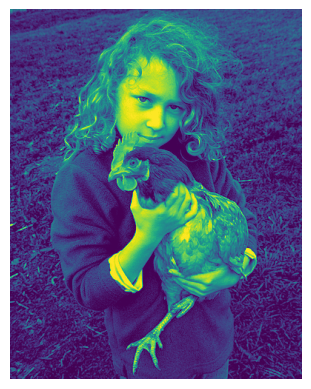


Top prediction:
a photo of a hen: 51.86%
a photo of a cock: 11.93%
a photo of a Brabancon griffon: 6.00%


In [9]:
for image_path in images:
    similarity, labels = classify(model_half, image_path)
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.show()
    values, indices = similarity[0].topk(3)
    print("\nTop prediction:")
    for value, index in zip(values, indices):
        print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")

We can observe that there are no significant changes in the result, as by turning the model to fp16, we are simply truncating the float point values in the model to make it fp16. This causes a small bit of information loss which is very small, and since the task is that of a simple one, the loss doesnt propogate to make it significant enough to give different probability scores.

100%|███████████████████████████████████████| 244M/244M [00:02<00:00, 99.4MiB/s]
/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:354: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


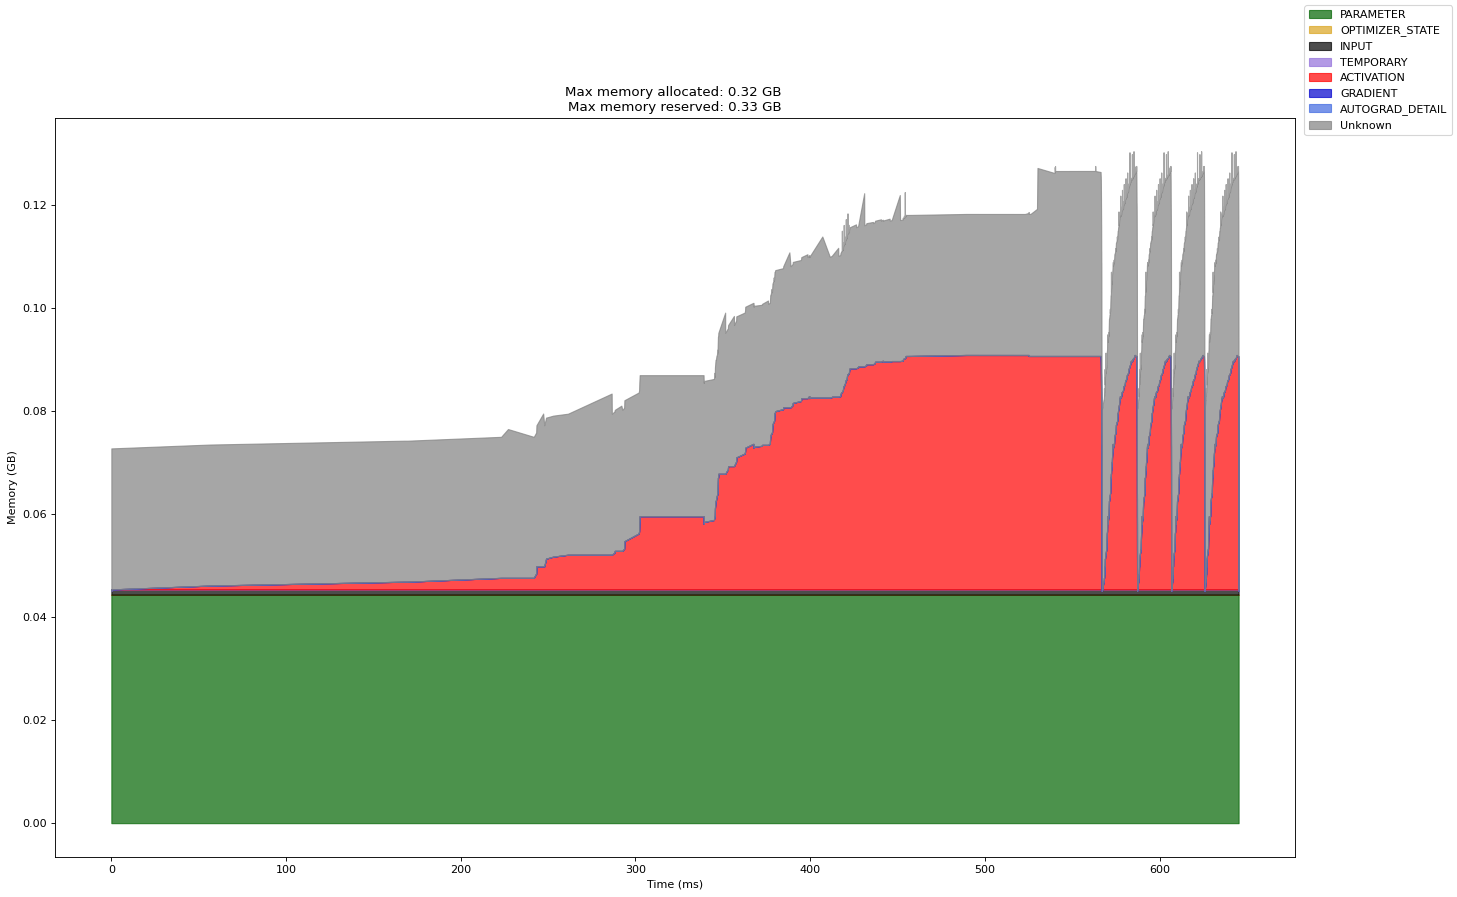

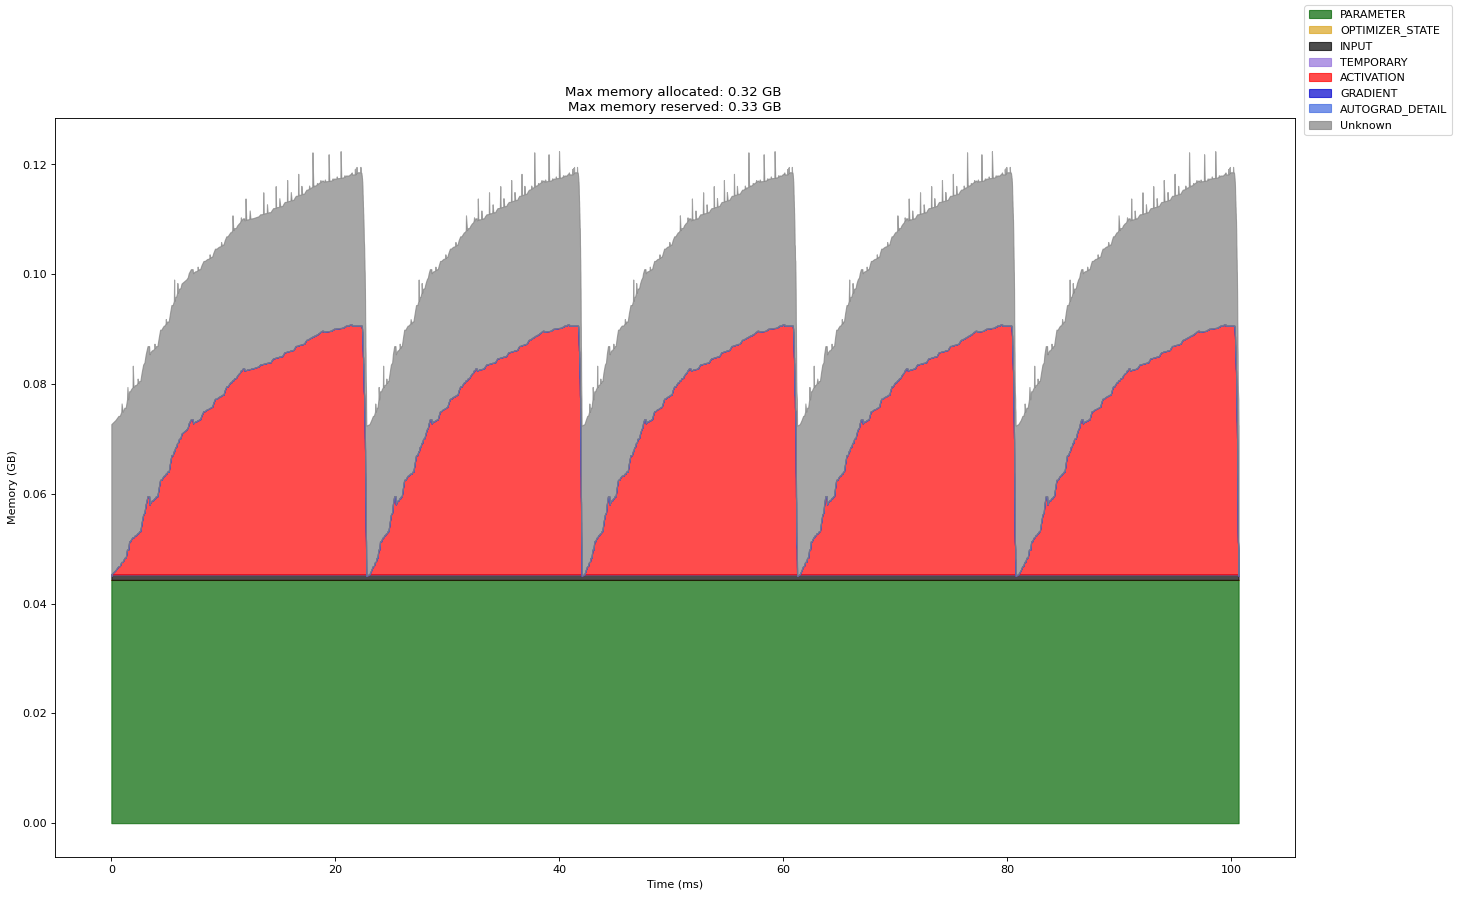

In [3]:
logging.basicConfig(
   format="%(levelname)s:%(asctime)s %(message)s",
   level=logging.INFO,
   datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"

def trace_handler(prof: torch.profiler.profile):
   # Prefix for file names.
   host_name = socket.gethostname()
   timestamp = datetime.now().strftime(TIME_FORMAT_STR)
   file_prefix = f"{host_name}_{timestamp}"

   # Construct the trace file.
   prof.export_chrome_trace(f"{file_prefix}.json.gz")

   # Construct the memory timeline file.
   prof.export_memory_timeline(f"{file_prefix}.html", device="cuda:0")

def run_clipfp32(num_iters=5, device="cuda:0"):
   model, preprocess = clip.load("RN50", device=device)
   image = preprocess(Image.open("bird.jpeg")).unsqueeze(0).to(device)

   with torch.profiler.profile(
       activities=[
           torch.profiler.ProfilerActivity.CPU,
           torch.profiler.ProfilerActivity.CUDA,
       ],
       schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
       record_shapes=True,
       profile_memory=True,
       with_stack=True,
       on_trace_ready=trace_handler,
   ) as prof:
       for _ in range(num_iters):
           prof.step()
           with record_function("## forward ##"):
               model.encode_image(image)

run_clipfp32()
run_clipfp32()


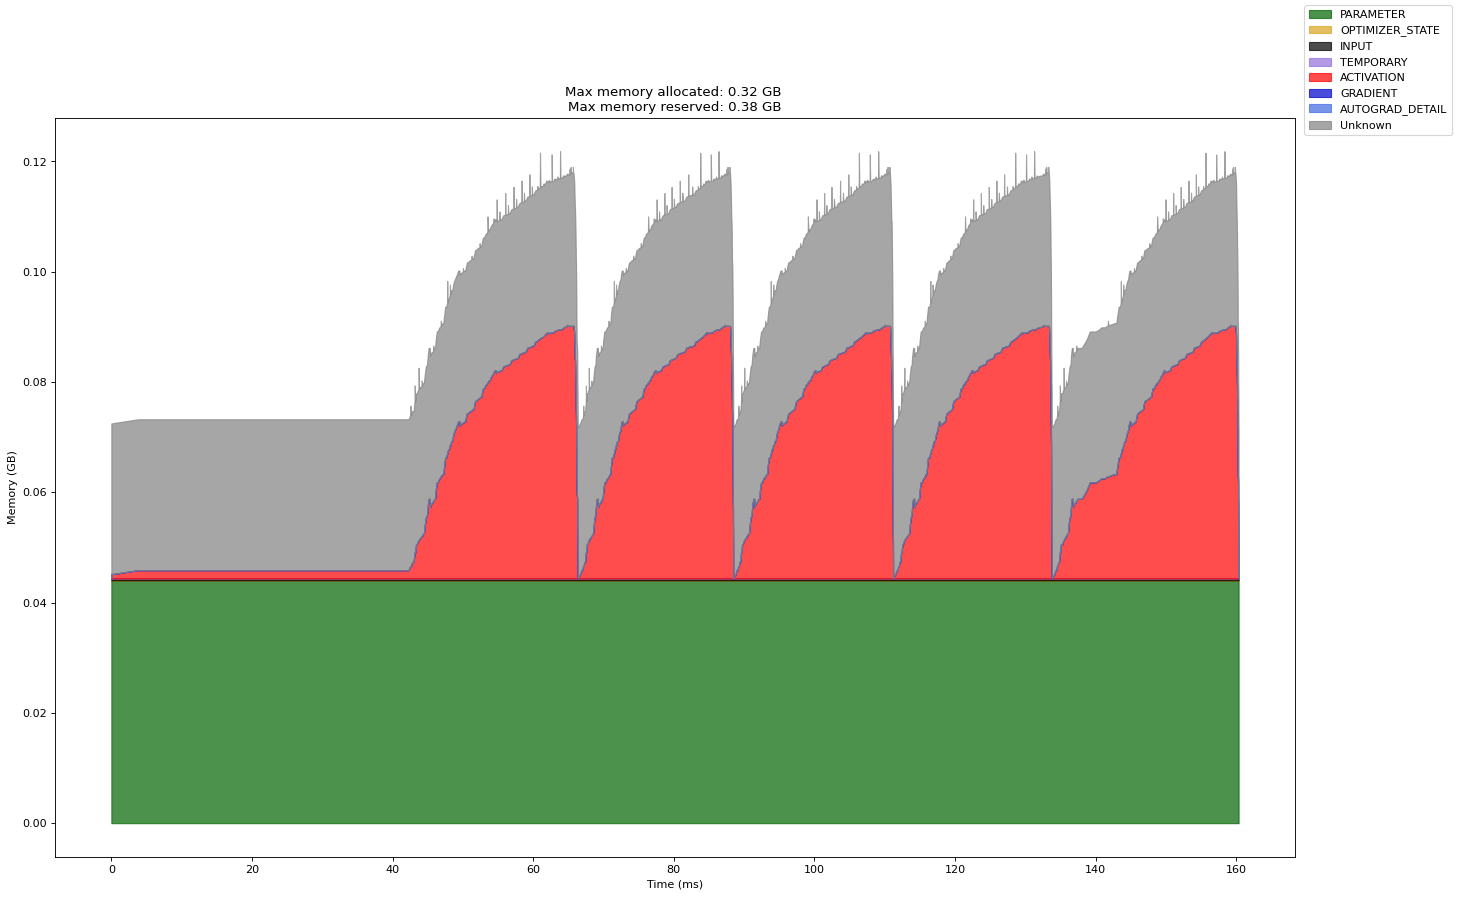

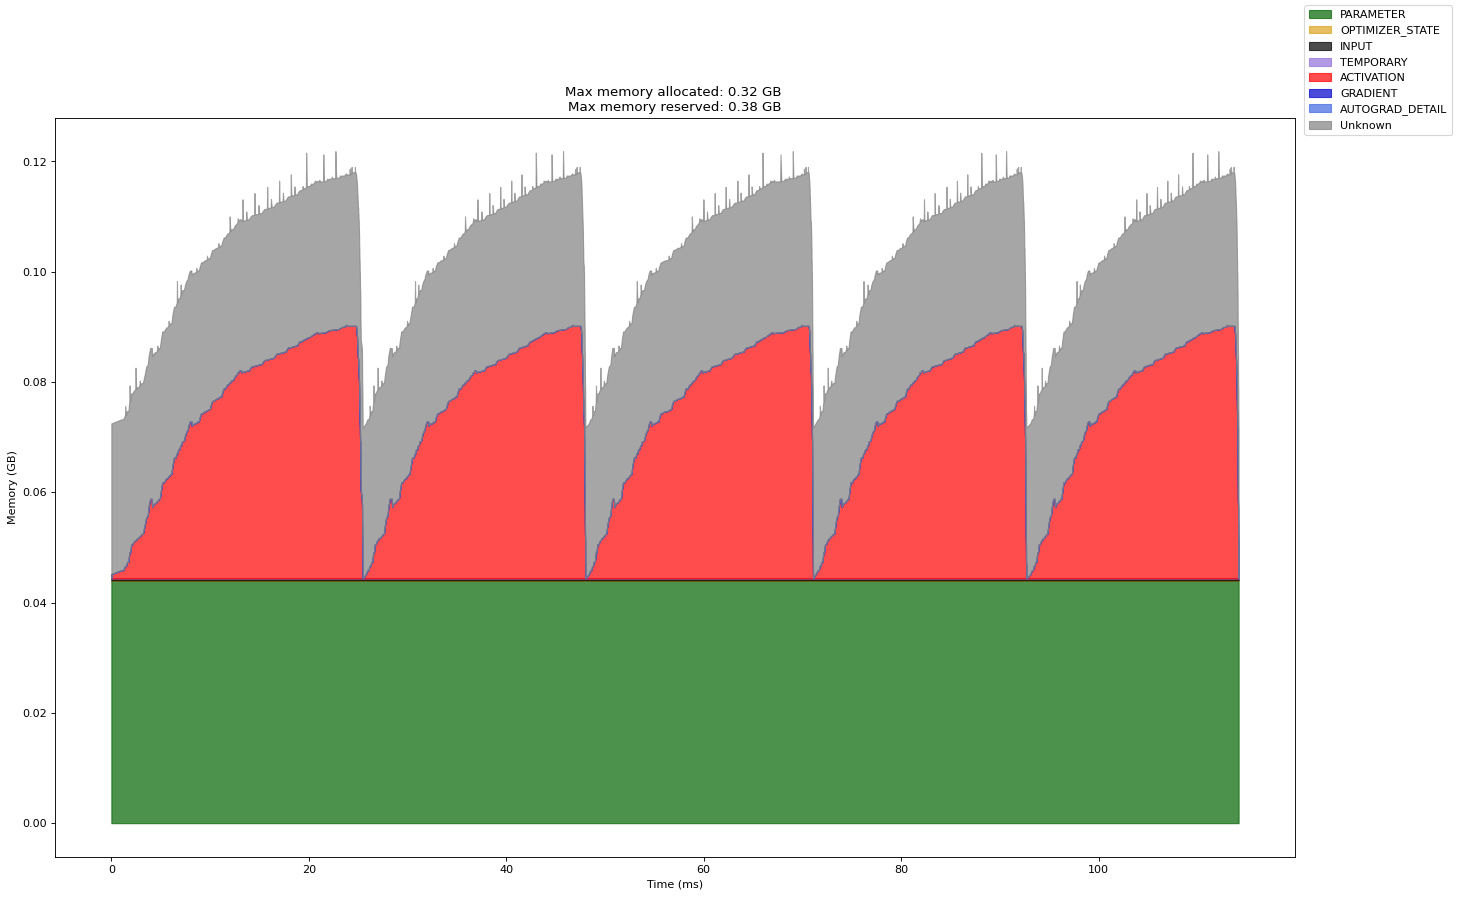

In [4]:
logging.basicConfig(
   format="%(levelname)s:%(asctime)s %(message)s",
   level=logging.INFO,
   datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"

def trace_handler(prof: torch.profiler.profile):
   # Prefix for file names.
   host_name = socket.gethostname()
   timestamp = datetime.now().strftime(TIME_FORMAT_STR)
   file_prefix = f"{host_name}_{timestamp}"

   # Construct the trace file.
   prof.export_chrome_trace(f"{file_prefix}.json.gz")

   # Construct the memory timeline file.
   prof.export_memory_timeline(f"{file_prefix}.html", device="cuda:0")

def run_clipfp16(num_iters=5, device="cuda:0"):
  model_half, preprocess = clip.load("RN50", device=device)
  model_half.half()
  image = preprocess(Image.open("bird.jpeg")).unsqueeze(0).to(device).half()

  with torch.profiler.profile(
      activities=[
          torch.profiler.ProfilerActivity.CPU,
          torch.profiler.ProfilerActivity.CUDA,
      ],
      schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
      record_shapes=True,
      profile_memory=True,
      with_stack=True,
      on_trace_ready=trace_handler,
  ) as prof:
      for _ in range(num_iters):
          prof.step()
          with record_function("## forward ##"):
              model_half.encode_image(image)

run_clipfp16()
run_clipfp16()